In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open(r'/content/drive/MyDrive/makemore/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:(i+1) for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {(i+1):s for i,s in enumerate(chars)}
itos[0] = '.'

In [ ]:
# build the dataset
block_size = 3

def build_dataset(words):
  X,Y = [],[]
  for w in words:
    context = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# simple MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)
b1 = torch.randn((n_hidden),generator=g)
W2 = torch.randn((n_hidden,27),generator=g)
b2 = torch.randn((27),generator=g)

parameters = [C,W1,b1,W2,b2]
print('number of parameters in total:',sum([p.nelement() for p in parameters]))

for p in parameters:
  p.requires_grad = True

number of parameters in total: 11897


In [ ]:
# training phase
# same optimization as before
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,),generator=g)
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward
  emb = C[Xb]
  h = torch.tanh(emb.view(Xb.shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Yb)

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000:27.8817
  10000/ 200000:2.9415
  20000/ 200000:2.5069
  30000/ 200000:2.7998
  40000/ 200000:2.0261
  50000/ 200000:2.5863
  60000/ 200000:2.3420
  70000/ 200000:2.0952
  80000/ 200000:2.3454
  90000/ 200000:2.2365
 100000/ 200000:2.1080
 110000/ 200000:2.3831
 120000/ 200000:1.9898
 130000/ 200000:2.4591
 140000/ 200000:2.1910
 150000/ 200000:2.1606
 160000/ 200000:2.1811
 170000/ 200000:1.7997
 180000/ 200000:2.0962
 190000/ 200000:1.8052


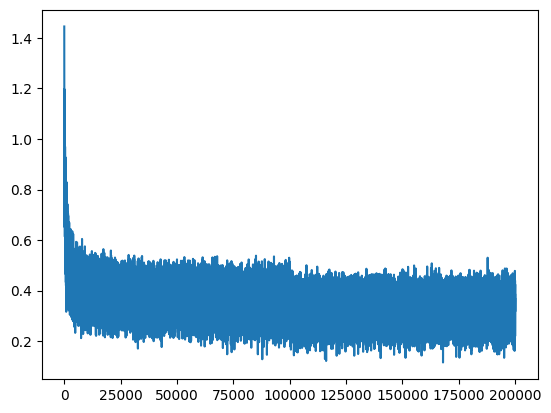

In [ ]:
plt.plot(lossi)

In [ ]:
# loss of the whole dataset
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
      'train':[Xtr,Ytr],
      'val':[Xdev,Ydev],
      'test':[Xte,Yte]
  }[split]
  emb = C[x]
  h = torch.tanh(emb.view(x.shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,y)
  print(split,loss)

split_loss('train')
split_loss('val')

train tensor(2.1277)
val tensor(2.1751)


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):

  out = []
  context = [0]*block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(emb.shape[0],-1)@W1+b1)
    logits = h@W2+b2
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
    out.append(itos[ix])
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(out))

junide.
jayca.
zou.
cory.
adria.
jirritolett.
aretzadahnia.
zamilena.
jededaine.
amel.


In [ ]:
# First, let's work on the parameters initialization
'''
  0/ 200000:26.5404
  10000/ 200000:2.8297
  20000/ 200000:2.5702
  30000/ 200000:2.2293
  40000/ 200000:2.3720
  50000/ 200000:2.7074
  60000/ 200000:2.3786
  70000/ 200000:2.3498
  80000/ 200000:2.1334
  90000/ 200000:2.0449
From the training losses before, we can see that the initial loss is pretty large (26.5 compared to 2.8), which means it's a pretty lame initialization.
At the very beginning, we assume that all the 27 characters are equally likely to appear, so it should be a uniform distribution.
Therefore, the initialized model should assign equal probability to each character.
'''
# So the initial loss should be
print('the expected loss is: ',-torch.tensor(1/27.0).log())

the expected loss is:  tensor(3.2958)


In [ ]:
# here is a 4-dim example of the issue
# let's assume that the entry with index=2 is the correct output
# if the entries of logits are all 0, which means the outputs are equally likely, then the loss is 1.38
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [ ]:
# if the entry with index=2 is pretty large in logits, which means the model predicts the right answer, then the loss is 0.02
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

In [ ]:
# if the entry with index=1 is pretty large in logits, which means the model predicts the wrong answer, then the loss is 5.05
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
probs,loss

(tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]), tensor(5.0553))

In [ ]:
# if the logits is a random guess, then the loss seems ok
logits = torch.randn((4))
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
logits,probs,loss

(tensor([-0.7653, -0.5769, -0.6533,  1.6741]),
 tensor([0.0676, 0.0816, 0.0756, 0.7752]),
 tensor(2.5820))

In [ ]:
# what's more, if the logits is a bigger random guess, then the loss will be quite large
logits = torch.randn((4)) * 100
probs = torch.softmax(logits,dim=0)
loss = -probs[2].log()
logits,probs,loss

(tensor([-150.2441,  123.6876,  -86.4373,  104.1755]),
 tensor([0.0000e+00, 1.0000e+00, 0.0000e+00, 3.3574e-09]),
 tensor(inf))

In [ ]:
# Therefore, for initialization, we want the entries of logits to be somehow likely to each other
# More commonly, we want them to be around 0, no one is too larger or smaller than others
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)
b1 = torch.randn((n_hidden),generator=g)
# ***********************************************
# here's the differece, for the output layer, we make the bias 0, and the weights small (note: we should never initialize weights to 0)
W2 = torch.randn((n_hidden,27),generator=g) * 0.01
b2 = torch.randn((27),generator=g)     * 0.0

parameters = [C,W1,b1,W2,b2]
print('number of parameters in total:',sum([p.nelement() for p in parameters]))

for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,),generator=g)
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward
  emb = C[Xb]
  h = torch.tanh(emb.view(Xb.shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Yb)

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
print(logits[0])

# we can see that the initial loss is now 3.31, which is much samller than before and very close to our goal
# the logits now is also small

number of parameters in total: 11897
      0/ 200000:3.3221
tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)


In [ ]:
# now let's train the model again
for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,),generator=g)
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward
  emb = C[Xb]
  h = torch.tanh(emb.view(Xb.shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Yb)

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000:3.1857
  10000/ 200000:1.8700
  20000/ 200000:1.9252
  30000/ 200000:2.0570
  40000/ 200000:2.2073
  50000/ 200000:2.1325
  60000/ 200000:2.1533
  70000/ 200000:2.8029
  80000/ 200000:2.6544
  90000/ 200000:2.2931
 100000/ 200000:2.2813
 110000/ 200000:1.8629
 120000/ 200000:2.1695
 130000/ 200000:1.9693
 140000/ 200000:1.8043
 150000/ 200000:2.4483
 160000/ 200000:2.2238
 170000/ 200000:1.7788
 180000/ 200000:1.9207
 190000/ 200000:2.1601


In [ ]:
split_loss('train')
split_loss('val')
# we can see that the results get better, compared to 2.16 and 2.12 before
# because we help the model to skip several (maybe thousands of) steps to just 'squash' the weights

train tensor(2.0696)
val tensor(2.1312)


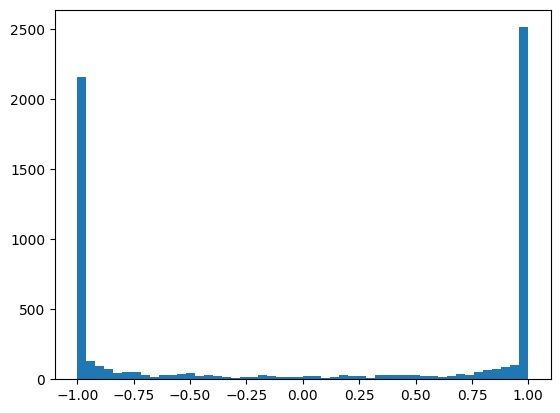

In [ ]:
# now we fix the logits, but there are still some problems with the first hidden layer output h
# from the distribution of h, we can see that lot's of values in h are -1 or 1
plt.hist(h.view(-1).tolist(),50);

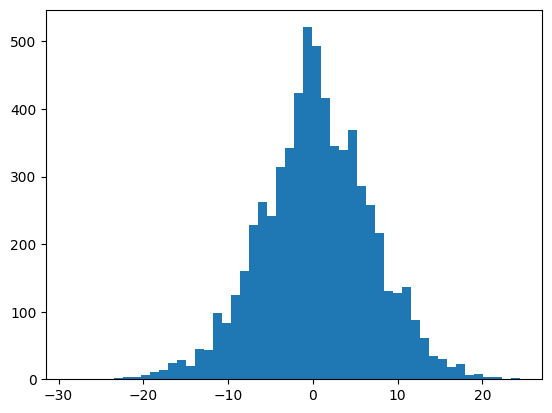

In [ ]:
# let's look at the distribution of the input of tanh
hpreact = emb.view(Xb.shape[0],-1)@W1+b1
plt.hist(hpreact.view(-1).tolist(),50);
# we can see that the values range is pretty broad
# for these large values, the gradient of tanh function will be 0, then gradient descent will not be working

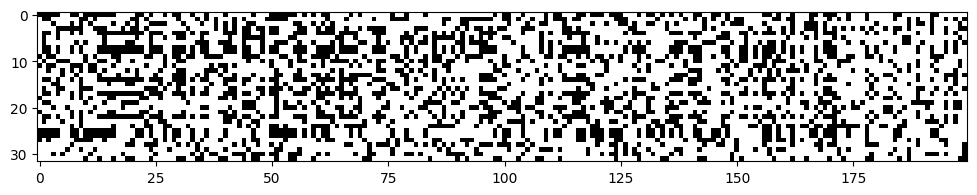

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')  # for a boolean tensor, you get white if it's true and black if it's false
# the size of this image is 32*200, for 32 examples and 200 neurons
# white points means h is bigger that 0.99, which means they are very activated by the examples and are in the plat tail
# if there's a column that all the points are white, then it's a dead neuron, because all the gradients are zero, and the neuron will never learn anything

In [ ]:
# even though there is no column that is all white, we still want to do better
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,n_embd),generator=g)
# ***********************************************
# here's the differece, we scale the bias and the weights by 0.1. (Though we can intialize bias to 0, Andrej suggests to set it to a small number)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g) * 0.1
b1 = torch.randn((n_hidden),generator=g)          * 0.01
W2 = torch.randn((n_hidden,27),generator=g)         * 0.01
b2 = torch.randn((27),generator=g)             * 0.0

parameters = [C,W1,b1,W2,b2]
print('number of parameters in total:',sum([p.nelement() for p in parameters]))

for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,),generator=g)
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward
  emb = C[Xb]
  h = torch.tanh(emb.view(Xb.shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Yb)

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())
  break
print(logits[0])

# we can see that the initial loss is now even smaller compared to 3.31

number of parameters in total: 11897
      0/ 200000:3.3069
tensor([-0.0405,  0.1421, -0.0283,  0.0199,  0.0547, -0.0121, -0.0171,  0.0049,
         0.0016,  0.0383,  0.1011, -0.0390,  0.0050, -0.1152, -0.0352,  0.0168,
        -0.0065, -0.0920, -0.1353, -0.0063,  0.0800,  0.0880,  0.0685, -0.0652,
        -0.0892,  0.0727,  0.0656], grad_fn=<SelectBackward0>)


In [ ]:
split_loss('train')
split_loss('val')
# we can see that the results get better, compared to 2.16 and 2.12 before

train tensor(3.2670)
val tensor(3.2672)


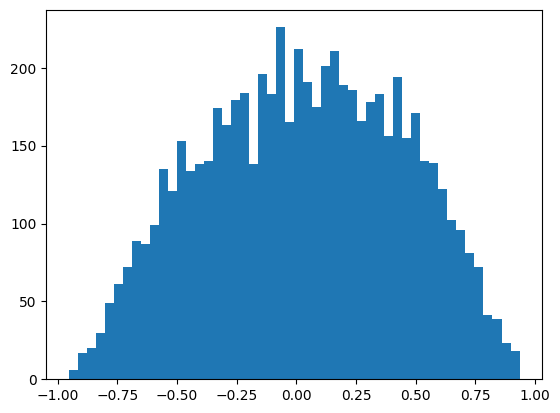

In [ ]:
plt.hist(h.view(-1).tolist(),50);

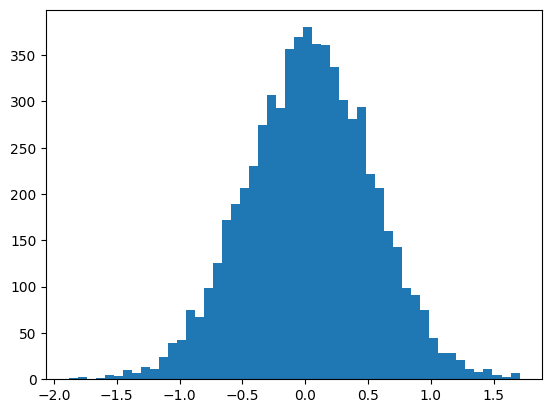

In [ ]:
hpreact = emb.view(Xb.shape[0],-1)@W1+b1
plt.hist(hpreact.view(-1).tolist(),50);

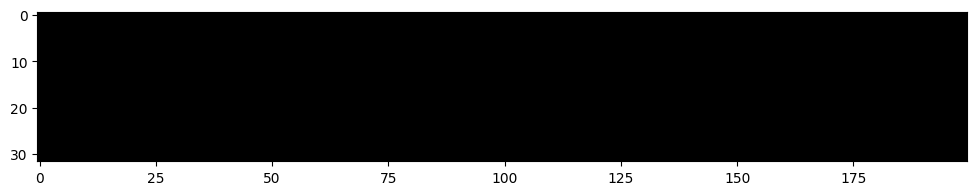

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')
# we can see that there is no white at all. Now the distribution looks much healthier.

tensor(0.0066) tensor(1.0050)
tensor(-0.0080) tensor(3.1261)


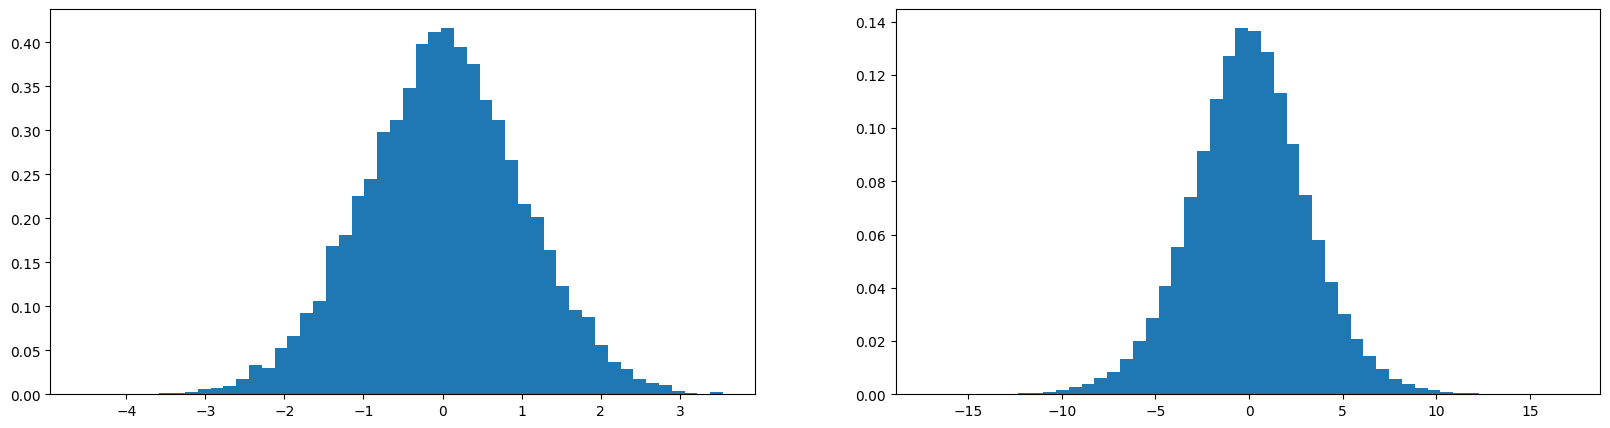

In [ ]:
# For a simple shallow network like this, even there are problems like this, it still can learn something and eventually gets the right answer, but only slower
# However, problems stack up in a deeper, bigger, more complicated neural network, it may never train at all if the initialization is bad enough
# In practice, no one manually set W1 = W1 * 0.01, b1 = b1 * 0.1, etc.
# Next is how we do it in pratice.
# Here's a simple motivation.
x = torch.randn((1000,10))
w = torch.randn((10,200))
y = x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);
# we can see that the distribution is expanded, as the means of x and y are both 0, but the std of x is 1 while std of y is 3

tensor(0.0100) tensor(0.9913)
tensor(0.0959) tensor(31.5998)


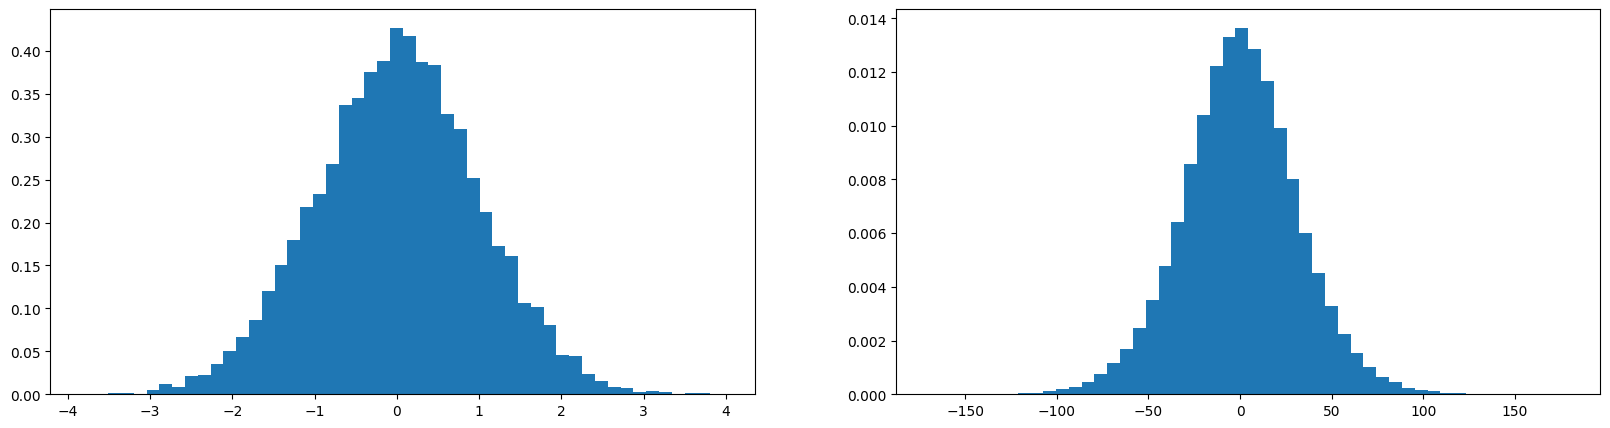

In [ ]:
x = torch.randn((1000,10))
w = torch.randn((10,200)) * 10
y = x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);
# if we scale the w by 10, the distribution will be even broader, while if we scale w by 0.2, the distribution will be more like a unit gaussian, which is what we want
# but what number should we use to scale w?
# kaiming initialization:
# in this case, the number for w1 should be: (5/3)/((n_embd*block_size)**0.5) (details: https://pytorch.org/docs/stable/nn.init.html)

In [ ]:
# However, for modern neural networks, it becomes less important to initialize weights and bias so precisely
# There are many innovations to make neural networks more stable and well-behaved
# Some of them are:
#   residual connections
#   normalization layers, like batch-normalization
#   better optimizers, like Adam

# Batch-Normalization

In [ ]:
# For tanh activation function, we want the input to be roughly normal distributed
# It can neither be too large so it falls in the flat area, nor be too small so the function doesn't take effect
# So why not just normalize them to be gaussian?

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,n_embd),generator=g)
W1 = torch.randn((block_size*n_embd,n_hidden),generator=g)
b1 = torch.randn((n_hidden),generator=g)
W2 = torch.randn((n_hidden,27),generator=g)
b2 = torch.randn((27),generator=g)

# scale and shift the norm
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

parameters = [C,W1,b1,W2,b2,bngain,bnbias]
for p in parameters:
  p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0,len(Xtr),(batch_size,))
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat@W1+b1
  # we want the hpreact to be initialized gaussian, so it won't be too large or too small for a tanh activation functon
  # but we don't want to force the hpreact to be gaussian forever, we want it to move around, and let the backpropagation to tell us how the distribution should move around
  # that's why we initialize scale (i.e. bngain) to be 1 and bias (i.e. bnbias) to be 0, and make them parameters that can be learned
  hpreact = bngain*((hpreact-hpreact.mean(dim=0,keepdims=True))/(hpreact.std(dim=0,keepdims=True)))+bnbias

  h = torch.tanh(hpreact)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

      0/ 200000:17.8443


In [ ]:
# take the mean of hpreact through the first dimension, i.e. mean over all the elements in the batch
hpreact.mean(dim=0,keepdims=True).shape
# similarly take the std
hpreact.std(dim=0,keepdims=True).shape

torch.Size([1, 200])

In [ ]:
'''
one thing worth mentioning:
  If we have a single example to the model, then it will be one example -> one output.
  Now for the sake of batch normalization duiring training, the logits of a example is not a function of just that example, but also a function of other examples that happenes to be in the same batch.
  So the output for one specific example will change slightly, depending on what other examples in the batch are.
  However, this may seem like a undesirable bug, but it actually turns out to be good in a strange way.
  The bonus side effect of this is regularization.
'''

'\none thing worth mentioning:\n  If we have a single example to the model, then it will be one example -> one output.\n  Now for the sake of batch normalization duiring training, the logits of a example is not a function of just that example, but also a function of other examples that happenes to be in the same batch.\n  So the output for one specific example will change slightly, depending on what other examples in the batch are.\n  However, this may seem like a undesirable bug, but it actually turns out to be good in a strange way.\n  The bonus side effect of this is regularization.\n'

In [ ]:
# how to input a single exmaple to the model with batch norm layer
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0,keepdims=True)
  bnstd = hpreact.std(0,keepdims=True)

# now that bnmean and bnstd are both fixed numbers, we can use them at test stage
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train':[Xtr,Ytr],
      'val':[Xdev,Ydev],
      'test':[Xte,Yte]
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat@W1+b1
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train'),split_loss('val')

train 16.251941680908203
val 16.21135902404785


(None, None)

In [ ]:
# However, in practice, no one add this extra stage to calculate bnmean and bnstd after training
# It's can be estimated during training.
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)
b1 = torch.randn((n_hidden),generator=g)
W2 = torch.randn((n_hidden,27),generator=g)
b2 = torch.randn((27),generator=g)

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

# these two variables are used to store the overall mean and std
# since the distribution is gaussian, mean is initialized as 0 and std as 1
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = {C,W1,b1,W2,b2,bngain,bnbias}
for p in parameters:
  p.requires_grad = True


lossi = []
for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0,len(Xtr),(batch_size,))
  Xb = Xtr[ix]
  Yb = Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0],-1)

  # Linear layer
  hpreact = embcat@W1+b1

  # BatchNorm layer
  bnmeani = hpreact.mean(dim=0,keepdims=True)
  bnstdi = hpreact.std(dim=0,keepdims=True)
  hpreact = bngain * (hpreact-bnmeani)/bnstdi + bnbias
  # update overall mean and std
  # note, these two variables have nothing to do with backpropagation
  # so we don't let them require grad, and update them with no grad
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.001
  for p in parameters:
    p.data -= lr*p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.item())

      0/ 200000:19.4828
  10000/ 200000:2.2484
  20000/ 200000:2.4978
  30000/ 200000:2.3709
  40000/ 200000:2.1383
  50000/ 200000:2.5086
  60000/ 200000:2.1726
  70000/ 200000:2.7777
  80000/ 200000:2.2303
  90000/ 200000:2.2219
 100000/ 200000:2.2153
 110000/ 200000:2.3865
 120000/ 200000:2.4328
 130000/ 200000:2.1496
 140000/ 200000:2.2498
 150000/ 200000:2.2996
 160000/ 200000:2.1960
 170000/ 200000:2.2304
 180000/ 200000:2.4149
 190000/ 200000:2.6528


In [ ]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat@W1+b1
  bnmean = hpreact.mean(dim=0,keepdims=True)
  bnstd = hpreact.std(dim=1,keepdim=True)

bnmean[:,:10], bnmean_running[:,:10]
# we can see that though not identical, they are very close, so we now don't need this second stage to calculate the mean and std

(tensor([[-8.1137,  2.0006, -4.1257,  6.6432,  6.9170,  4.5602,  5.3624, -4.6348,
          -4.7743,  3.0406]]),
 tensor([[-8.0554,  1.9667, -4.1290,  6.5810,  6.9829,  4.5762,  5.3478, -4.5833,
          -4.7469,  3.0499]]))

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train':(Xtr,Ytr),
      'val':(Xdev,Ydev),
      'test':(Xte,Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat@W1+b1
  hpreact = bngain*(hpreact-bnmean_running)/bnstd_running + bnbias # now we can replace bnmean and bnstd with bnmean_running and bnstd_running
  h = torch.tanh(hpreact)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,y)
  print(loss.item())

split_loss('train')
split_loss('val')

2.193122386932373
2.1988909244537354


In [ ]:
# two more things about batch normalization (don't run this cell, it's not valid code)
# 1. here we can add a epsilon here to avoid division by zero error
epsilon = 1e-5
hpreact = bngain * (hpreact-bnmeani)/(bnstdi+epsilon) + bnbias

# 2. here, note this bias b1 is useless because whatever b1 you add here will be subtracted when batch nomralization
hpreact = embcat@W1+b1
bnmeani = hpreact.mean(dim=0,keepdims=True)
bnstdi = hpreact.std(dim=0,keepdims=True)
hpreact = (hpreact - bnmeani) / bnstdi
# so this b1 can be dropped, otherwise it is subtly wasteful
# and now it's the batch normalization bias that is in charge of bias the distribution
hpreact = bngain * hpreact + bnbias

Example of resnet pytorch: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

Details about linear layer in pytorch: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

Details about batchnorm in pytorch: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

# Pytorch-ify the code

In [ ]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    # here we scale the weights
    self.weight = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5
    # if bias==False, then there is no bias, and it means we are going to apply batch normalization after this linear layer
    # if bias==True, then we initialize bias to be zeros
    self.bias = torch.zeros(fan_out) if bias else None
  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self,dim,eps=1e-5,momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True      # it's used to decide whether this is used for training phase or for testing phase
    self.gamma = torch.ones(dim)  # this is the bn_gain
    self.beta = torch.zeros(dim)  # this is the bn_bias
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  def __call__(self,x):
    if self.training:
      xmean = x.mean(dim=0,keepdim=True)
      xvar = x.var(dim=0,keepdim=True,correction=1) # difference between the sample size and sample degrees of freedom. Changed in version 2.0: Previously this argument was called unbiased and was a boolean with True corresponding to correction=1 and False being correction=0.
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    return self.out
  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
vocab_size = 27
g= torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_embd),generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(     n_hidden, n_hidden), Tanh(),
    Linear(     n_hidden, n_hidden), Tanh(),
    Linear(     n_hidden, n_hidden), Tanh(),
    Linear(     n_hidden, n_hidden), Tanh(),
    Linear(     n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight *= 5/3     # kaiming_norm

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
max_step = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0,len(Xtr),(batch_size,),generator=g)
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # Enables this Tensor to have their grad populated during backward()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_step:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

  if i>=1000:
    break

      0/ 200000: 3.2962


layer 1 {      Tanh}: mean -0.04, std 0.76, saturated: 21.97%
layer 3 {      Tanh}: mean -0.01, std 0.72, saturated: 11.00%
layer 5 {      Tanh}: mean +0.01, std 0.73, saturated: 13.00%
layer 7 {      Tanh}: mean -0.05, std 0.73, saturated: 13.34%
layer 9 {      Tanh}: mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

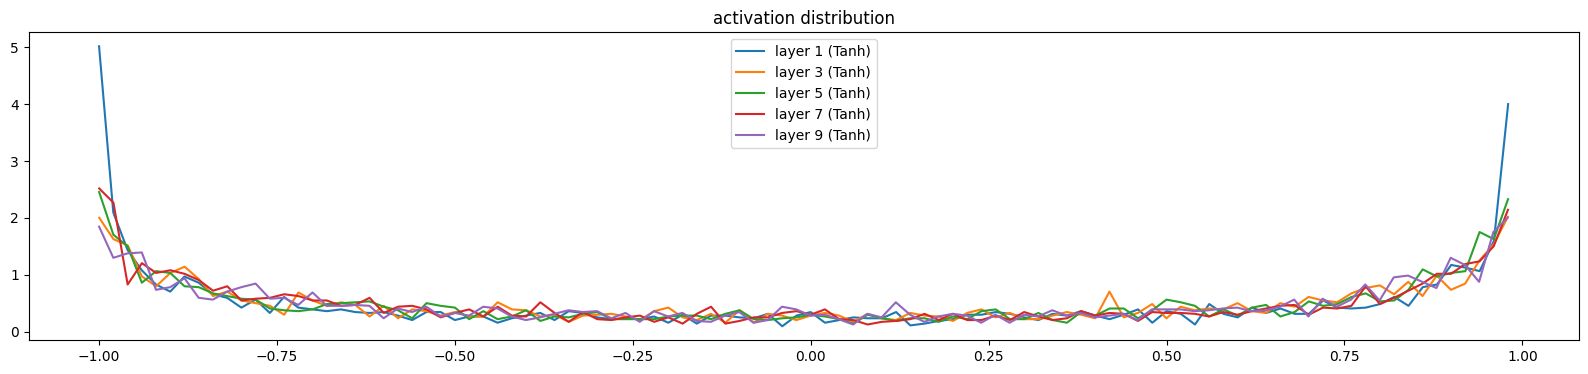

In [ ]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer,Tanh):
    t = layer.out
    print('layer %d {%10s}: mean %+.2f, std %.2f, saturated: %.2f%%'%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

# this graph and the graph of the next cell are highly related to the weights here
# play with the number to see what happens
# for layer in layers[:-1]:
#     if isinstance(layer,Linear):
#       layer.weight *= 2     # kaiming_norm
# if the scale is too large, then many outputs will be saturated
# if the scale is too small, then outputs of deeper layer tends to shrink down to 0
# so 5/3 is a decent value for linear layers followed by tanh activation

layer 1 (      Tanh): mean: +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean: +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean: -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean: +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean: +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

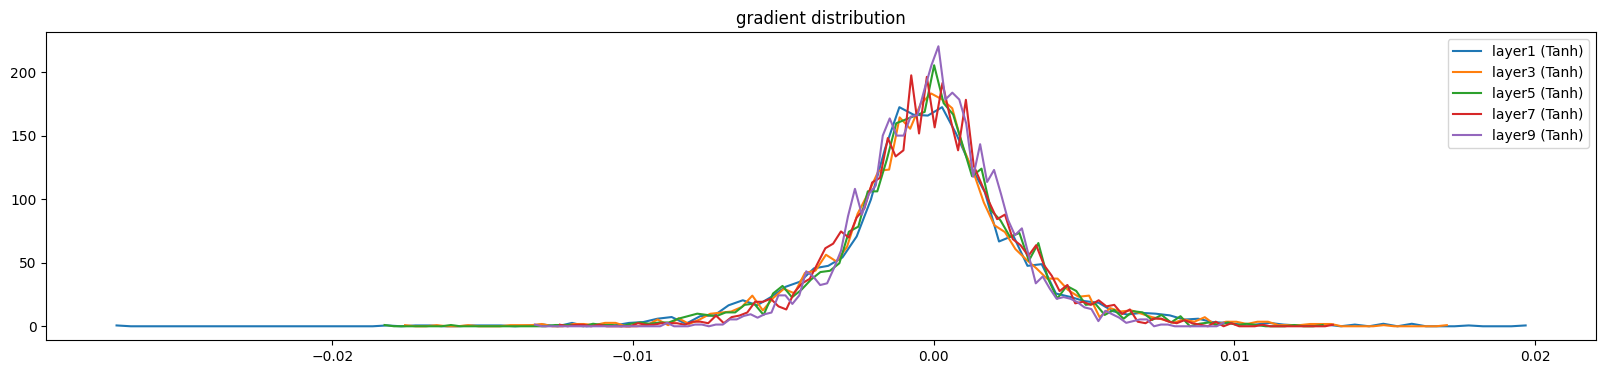

In [ ]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean: %+f, std %e' % (i,layer.__class__.__name__,t.mean(),t.std()))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
# we can see that the gradients of all the layers are roughly the same, things are not shrinking or exploding
# if the scale is too large, then many outputs will be saturated, i.e. the gradients will tend to be zeros especially when the layer is going deeper
# if the scale is too small, then outputs of deeper layer tends to shrink down to 0, i.e. the gradients will tend to explode especially when the layer is going deeper
# so again, 5/3 is a decent value for linear layers followed by tanh activation

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean -0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


Text(0.5, 1.0, 'weight gradient distribution')

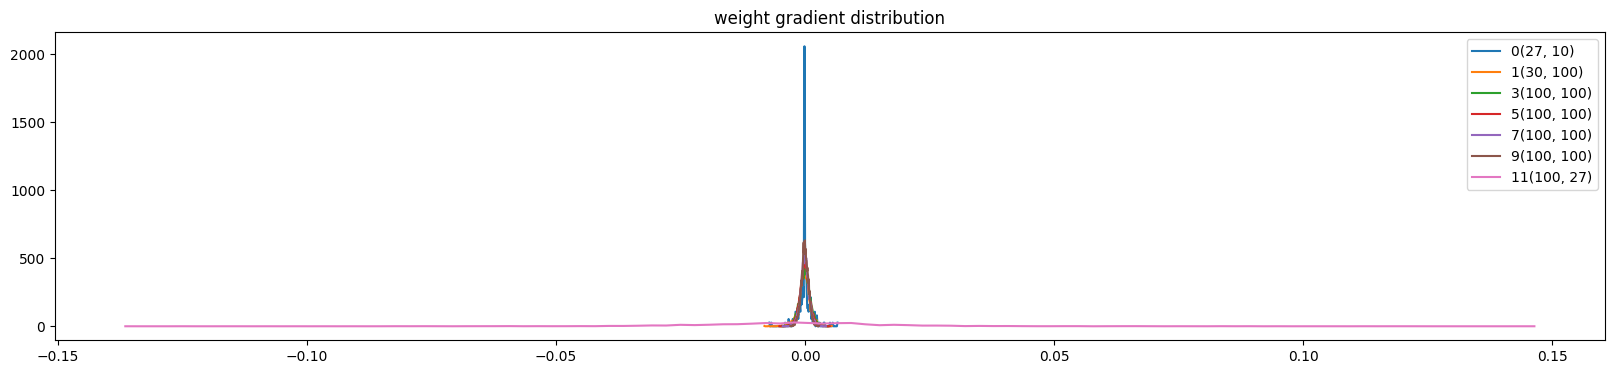

In [ ]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distribution')

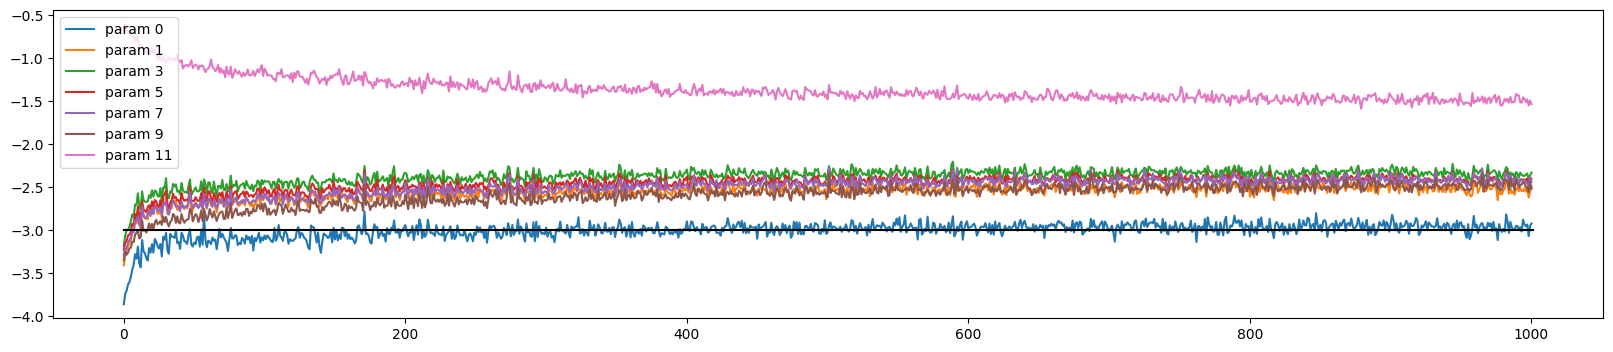

In [ ]:
# visualize histogram
# ud stores the magnitudes of grads over magnitudes of values during training
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
# this graph is highly related to learning rate
# this is one thing we should keep tracking of, it helps us determine what learning rate we should use

In [ ]:
# Note, now we're not using the batchnorm layer, so we have to carefully choose the scale of linear layers weight
# Now, let's add batchnorm layers to our network
C = torch.randn((vocab_size,n_embd),generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(     n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(     n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(     n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(     n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(     n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1           # for the output, it's now not the weight but the gamma that determines the output weight
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer,Linear):
      layer.weight *= 5/3     # kaiming_norm

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47551


In [ ]:
max_step = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0,len(Xtr),(batch_size,),generator=g)
  Xb,Yb = Xtr[ix],Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # Enables this Tensor to have their grad populated during backward()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_step:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])

  if i>=1000:
    break

      0/ 200000: 3.3216


layer 2 {      Tanh}: mean +0.00, std 0.63, saturated: 3.22%
layer 5 {      Tanh}: mean -0.00, std 0.64, saturated: 2.72%
layer 8 {      Tanh}: mean -0.00, std 0.64, saturated: 2.72%
layer 11 {      Tanh}: mean +0.01, std 0.65, saturated: 1.94%
layer 14 {      Tanh}: mean -0.00, std 0.65, saturated: 1.62%


Text(0.5, 1.0, 'activation distribution')

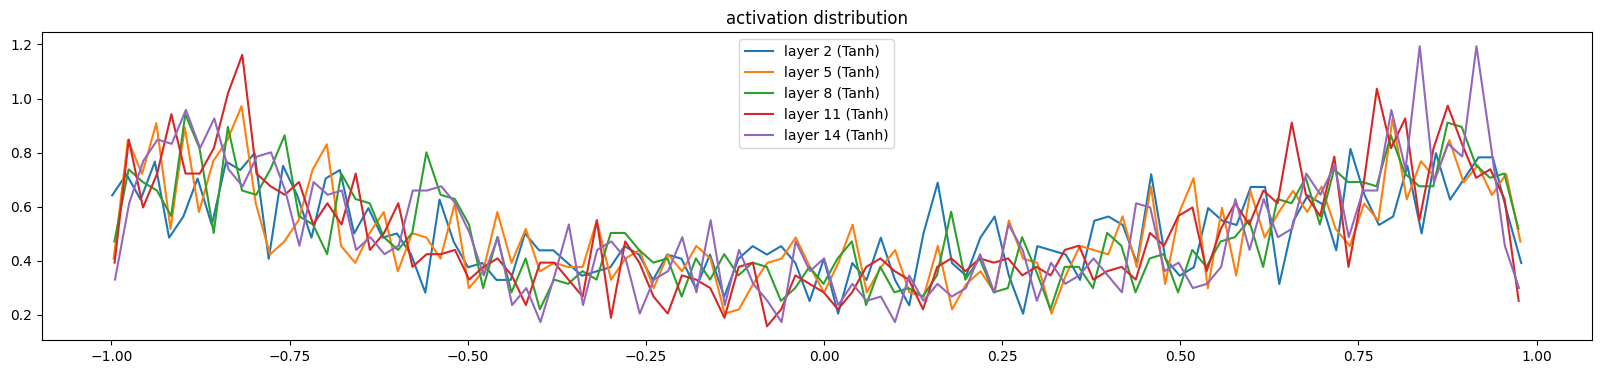

In [ ]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer,Tanh):
    t = layer.out
    print('layer %d {%10s}: mean %+.2f, std %.2f, saturated: %.2f%%'%(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

# as we use batch norm, now these two distributuion will be more stable and less sensitive to weight scales
# so we don't neccessarily need
# layer.weight *= 5/3     # kaiming_norm
# nor the fan_in**0.5 part
# self.weight = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5

layer 2 (      Tanh): mean: -0.000000, std 2.690740e-03
layer 5 (      Tanh): mean: -0.000000, std 2.239516e-03
layer 8 (      Tanh): mean: -0.000000, std 2.185354e-03
layer 11 (      Tanh): mean: +0.000000, std 2.052057e-03
layer 14 (      Tanh): mean: +0.000000, std 2.124366e-03


Text(0.5, 1.0, 'gradient distribution')

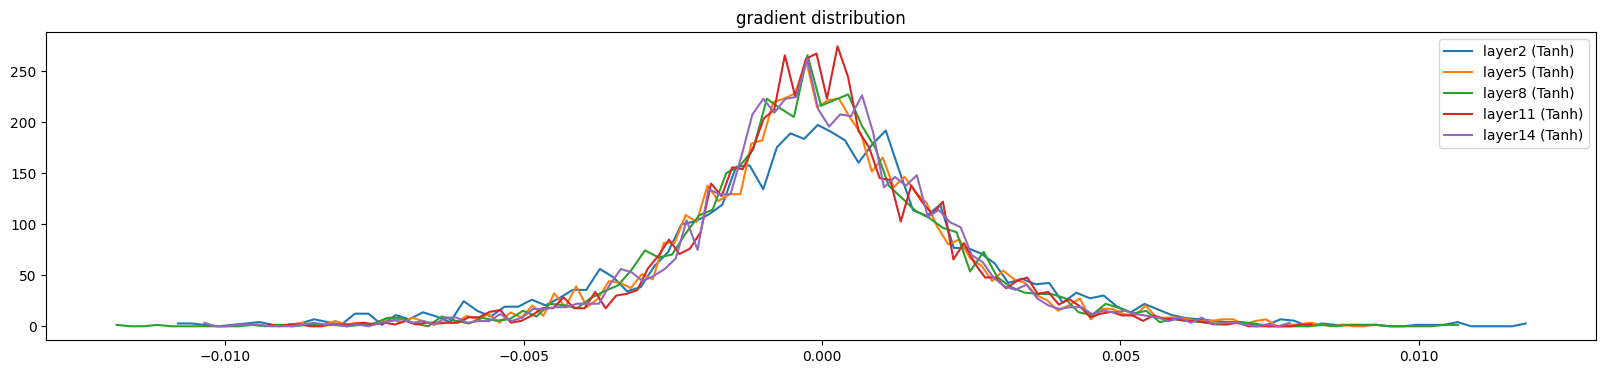

In [ ]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean: %+f, std %e' % (i,layer.__class__.__name__,t.mean(),t.std()))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'layer{i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 7.629252e-03 | grad:data ratio 7.324844e-03
weight  (30, 100) | mean +0.000128 | std 6.282386e-03 | grad:data ratio 2.062234e-02
weight (100, 100) | mean -0.000017 | std 4.966536e-03 | grad:data ratio 2.941076e-02
weight (100, 100) | mean +0.000027 | std 4.669977e-03 | grad:data ratio 2.795143e-02
weight (100, 100) | mean -0.000033 | std 4.421845e-03 | grad:data ratio 2.633522e-02
weight (100, 100) | mean +0.000008 | std 4.287765e-03 | grad:data ratio 2.562900e-02
weight  (100, 27) | mean -0.000015 | std 8.238792e-03 | grad:data ratio 4.856119e-02


Text(0.5, 1.0, 'weight gradient distribution')

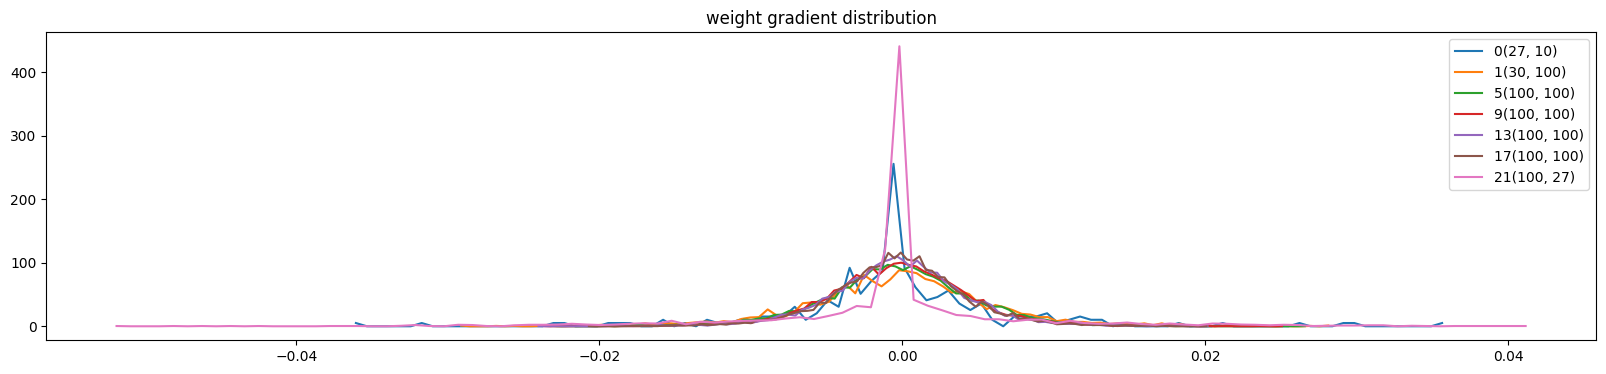

In [ ]:
# visualize histogram
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
    hy,hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'{i}{tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distribution')

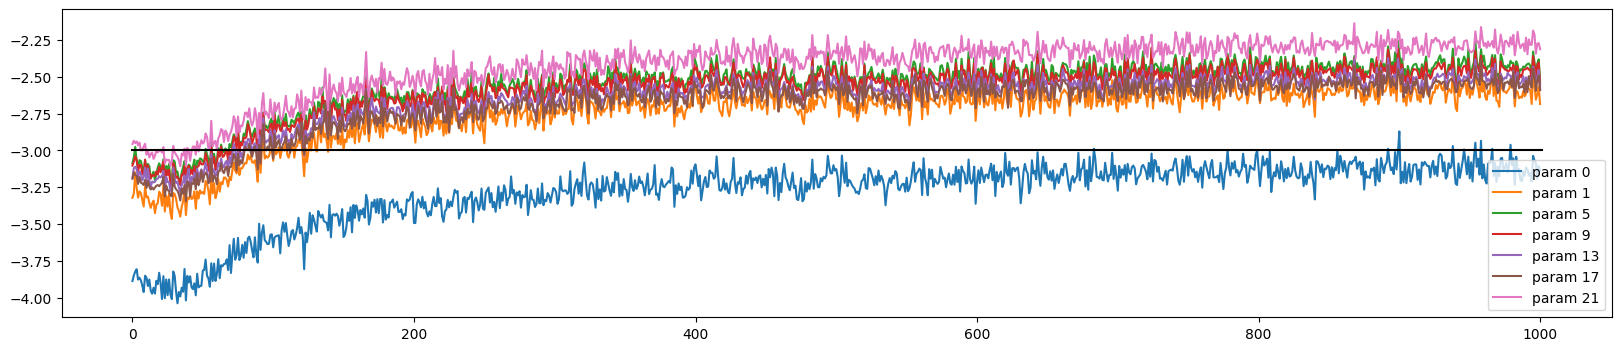

In [ ]:
# visualize histogram
# ud stores the magnitudes of grads over magnitudes of values during training
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0,len(ud)],[-3,-3],'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
# with batch normalization, we should adjust the learning rate
# Andrej shows that lr = 1.0 works fine